# PyTorch Classification

In [1]:
import pandas as pd
df = pd.read_csv('heart_failure.csv')
print(df.shape)
df.head()

(299, 15)


,Unnamed: 0,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,death_event
0,0,75.0,no,582,no,20,yes,265000.00,1.9,130,yes,no,4,1,yes
1,1,55.0,no,7861,no,38,no,263358.03,1.1,136,yes,no,6,1,yes
2,2,65.0,no,146,no,20,no,162000.00,1.3,129,yes,yes,7,1,yes
3,3,50.0,yes,111,no,20,no,210000.00,1.9,137,yes,no,7,1,yes
4,4,65.0,yes,160,yes,20,no,327000.00,2.7,116,no,no,8,1,yes


### Define X and y

In [2]:
y = df['DEATH_EVENT']
X = df.loc[:,'age':'time']

### Split data

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.5, 
                                                    random_state = 7
                                                   )

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(149, 12) (150, 12) (149,) (150,)


### Column Transformer (Scale Data & OHE)

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder,  OneHotEncoder

# define the columns and their transformations
preprocessor = ColumnTransformer([("numeric", 
                                     StandardScaler(),
                                    ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets',
                                     'serum_creatinine', 'serum_sodium', 'time',]), 
                                   
                                   ("categorical",
                                    OneHotEncoder(),
                                    ['anaemia','diabetes', 'high_blood_pressure', 'sex', 'smoking' ])

                                   ])
preprocessor

ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                 ['age', 'creatinine_phosphokinase',
                                  'ejection_fraction', 'platelets',
                                  'serum_creatinine', 'serum_sodium', 'time']),
                                ('categorical', OneHotEncoder(),
                                 ['anaemia', 'diabetes', 'high_blood_pressure',
                                  'sex', 'smoking'])])

In [5]:
# fit the preprocessor 
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

### Convert to Tensors

In [6]:
# Convert y data into numpy array first / X data is already in numpy array type
y_train = y_train.values
y_test = y_test.values

In [7]:
import torch
X_train = torch.from_numpy(X_train).type(torch.float)
y_train = torch.from_numpy(y_train).type(torch.float)
X_test = torch.from_numpy(X_test).type(torch.float)
y_test = torch.from_numpy(y_test).type(torch.float)
print(type(X_train), type(X_test), type(y_train), type(y_test))

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>


***

### Create a Model

In [8]:
# Create a Neural Network Class
from torch import nn
class Neural_Net_V0(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(in_features=17, out_features=34)
        self.layer_2 = nn.Linear(in_features=34, out_features=34)
        self.layer_3 = nn.Linear(in_features=34, out_features=1)
        # add relU activation function
        self.relu = nn.ReLU() #  non-linear activation function
#         self.sigmoid = nn.Sigmoid() # note: usually sigmoid function is implemented here but since were using 
#                                             nn.BCEWithLogitsLoss(), we will apply the sigmoid fucntion in our logits
#                                             value in the Training loops.

    def forward(self, x):
#         z = self.layer_1(x)
#         z = self.layer_2(z)
#         z = self.layer_3(z)
        return  self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    
model_2 = Neural_Net_V0()
model_2

Neural_Net_V0(
  (layer_1): Linear(in_features=17, out_features=34, bias=True)
  (layer_2): Linear(in_features=34, out_features=34, bias=True)
  (layer_3): Linear(in_features=34, out_features=1, bias=True)
  (relu): ReLU()
)

### Accuracy Function

In [9]:
def accuracy_fn(y_train, y_pred):
    correct = torch.eq(y_train, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc 

### Loss Fucntion and Optimizer

In [10]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                           lr = 0.1)

### Training Loops

In [11]:
# Build traning and evaluation loop on `model_2`

torch.manual_seed(42)
epochs = 1000
for epoch in range(epochs):
    ########TRAININGI MODE########
    model_2.train()
    # Forward pass
    y_logits = model_2(X_train).squeeze() # convert to 1 dimension / logits is the raw prediction data
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> sigmoid function -> pred probability -> pred labels   
    # Calcualte loss/accuracy
    loss = loss_fn(y_logits, # nn.BCEWithLogitdLoss expect raw logits as input
                   y_train)
    acc = accuracy_fn(y_train,
                      y_pred)
    # Optimizer zero grad
    optimizer.zero_grad()    
    # loss backward
    loss.backward()   
    # Optimizer step
    optimizer.step()  
    ########TESTING MODE########
    model_2.eval()
    with torch.inference_mode():
        # forward pass
        test_logits = model_2(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # calculate the test_loss/accurary
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_test,
                          test_pred)
        if epoch % 100 == 0:
            print(f'Epoch:{epoch}, | Loss:{loss:.5f} | Acc"{acc:.2f}% | Test Loss:{test_loss:.5f} | Test Acc:{test_acc:.2f}')

Epoch:0, | Loss:0.66711 | Acc"67.79% | Test Loss:0.66723 | Test Acc:68.00
Epoch:100, | Loss:0.47283 | Acc"75.84% | Test Loss:0.47340 | Test Acc:74.67
Epoch:200, | Loss:0.37482 | Acc"83.22% | Test Loss:0.38526 | Test Acc:83.33
Epoch:300, | Loss:0.32496 | Acc"87.25% | Test Loss:0.38634 | Test Acc:84.67
Epoch:400, | Loss:0.26484 | Acc"90.60% | Test Loss:0.40345 | Test Acc:84.67
Epoch:500, | Loss:0.19309 | Acc"94.63% | Test Loss:0.46615 | Test Acc:84.67
Epoch:600, | Loss:0.12611 | Acc"97.99% | Test Loss:0.58637 | Test Acc:82.67
Epoch:700, | Loss:0.07913 | Acc"99.33% | Test Loss:0.73514 | Test Acc:80.00
Epoch:800, | Loss:0.04995 | Acc"100.00% | Test Loss:0.88241 | Test Acc:79.33
Epoch:900, | Loss:0.03319 | Acc"100.00% | Test Loss:1.01292 | Test Acc:78.67


### Import our Helper Function

In [23]:
import requests
from pathlib import Path

# Downloading helper_functions from learn PyTorch repo (if not already downloaded)
if Path('helper_fucntion.py').is_file():
    print('helper_function already exist, skipping download')    
else:
    print('Downloading helper_fucntion.py')
    # download the raw file
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
    with open ('helper_functions.py', 'wb') as f:
           f.write(request.content)            

In [24]:
from helper_functions import plot_predictions, plot_decision_boundary

### Plot Decision Boundary of the Model

`Note:` We can only plot a 2D (two features) space or even 3D (Three feature) space. If you knew an apps or code than can visualize N number of dimensions, please let me know. 

In [26]:
# Visualize! Visualize! Visualize!
# plt.figure(figsize=(12,6))

# plt.subplot(1,2,1)
# plt.title('Train')
# plot_decision_boundary(model_2, X_train, y_train)

# plt.subplot(1,2,2)
# plt.title('Test')
# plot_decision_boundary(model_2, X_test, y_test)

### Confusion Matrix

In [27]:
from sklearn.metrics import confusion_matrix
model_matrix = confusion_matrix(y_test, test_pred)
model_matrix

array([[88, 14],
       [18, 30]], dtype=int64)

<AxesSubplot:>

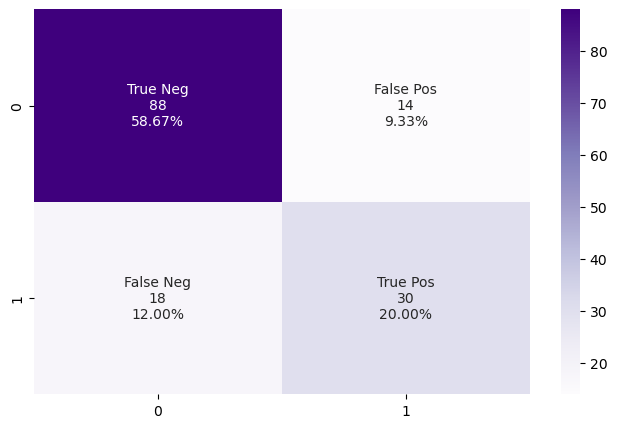

In [28]:
# Visualize
import numpy as np
import seaborn as sns

fig, ax = plt.subplots(figsize=(8,5))
# setting variables
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in model_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in model_matrix.flatten()/np.sum(model_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(model_matrix, annot=labels, fmt='', cmap='Purples')